<a href="https://colab.research.google.com/github/aderdouri/ActuarialThesis/blob/master/myRegressorsCompare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Régression CatBoost

## Cloner la branche contenant le dataset et le code qui va avec.

In [2]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 872, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 872 (delta 73), reused 113 (delta 41), pack-reused 717
Receiving objects: 100% (872/872), 123.29 MiB | 37.42 MiB/s, done.
Resolving deltas: 100% (363/363), done.
total 96
drwxr-xr-x 2 root root  4096 Oct 26 13:09 AllstateClaimPredictionChallenge/
drwxr-xr-x 2 root root  4096 Oct 26 13:09 AllstateClaimsSeverity/
drwxr-xr-x 2 root root  4096 Oct 26 13:09 Data/
drwxr-xr-x 2 root root  4096 Oct 26 13:09 EMTboost/
drwxr-xr-x 2 root root  4096 Oct 26 13:09 FrenchMotorThirdPartyLiabilityClaims/
drwxr-xr-x 2 root root  4096 Oct 26 13:09 Models/
-rw-r--r-- 1 root root    54 Oct 26 13:09 README.md
drwxr-xr-x 2 root root  4096 Oct 26 13:09 Plots/
drwxr-xr-x 2 root root  4096 Oct 26 13:09 Notebooks/
drwxr-xr-x 2 root root  4096 Oct 26 13:09 src/
-rw-r--r-- 1 root root 19545 Oct 26 13:09 myXGBoostRegressor.ipynb
-r

In [6]:
!mkdir ActuarialThesis/plots_rgr
!ls -ltr ActuarialThesis/plots_rgr

mkdir: cannot create directory ‘ActuarialThesis/plots_rgr’: File exists
total 0


In [7]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [8]:
import installHelper

In [9]:
# Installer les packages nécéssaires
%time installHelper.installALL()

CPU times: user 746 ms, sys: 108 ms, total: 854 ms
Wall time: 2min 32s


In [10]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


In [11]:
# Importer les packages nécéssaires
from helper import *

In [12]:
# Appliquer le theme par défaut
sns.set_theme()

## Partir du dataset déjà encodé.

In [13]:
# Partir du dataset déja encodé et splité en Train/Test
df_train = pd.read_csv('ActuarialThesis/Data/encodedTrainBASEAUTO.csv')
df_test = pd.read_csv('ActuarialThesis/Data/encodedTestBASEAUTO.csv')
df_train.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR_AUTRE,CAR_BER,CAR_BRK,CAR_CTE,...,SEGM_M2,GARAGE_1,GARAGE_2,GARAGE_3,CSP_1,CSP_50,CSP_55,CSP_60,CSP_AUTRE,CHARGE
0,-0.551995,1,0,2.524444,1,-0.817279,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
1,-1.114303,0,0,0.762290,0,-0.817279,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
2,0.853775,0,1,-1.067640,0,0.732469,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2154.048943
3,-1.114303,0,0,-0.864314,0,-0.817279,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000
4,-1.395457,0,0,-1.067640,0,-0.300697,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,772.435649


## Option 2 of the split:

In [14]:
X_train = df_train.drop('CHARGE', axis=1)
y_train = df_train['CHARGE']

X_test = df_test.drop('CHARGE', axis=1)
y_test = df_test['CHARGE']

# Split the train set into Train/Val sets: 80:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

## CatBoostRegressor

In [15]:
from catboost import Pool

train_pool = Pool(X_train, label = y_train)
test_pool = Pool(X_test, label = y_test)

cb_tweedie = CatBoostRegressor(n_estimators=1000,
                               loss_function='Tweedie:variance_power=1.9',
                               silent=True)
cb_tweedie.fit(train_pool, eval_set=test_pool)

cb_rmse = CatBoostRegressor(n_estimators=1000, loss_function='RMSE', silent=True)
cb_rmse.fit(train_pool, eval_set=test_pool)

In [38]:
y_pred_rmse_tweedie = np.clip(cb_rmse.predict(test_pool), 0, None)
y_pred_cb_tweedie = cb_tweedie.predict(test_pool)

In [29]:
# Mean squared logarithmic error (MSLE)
from catboost.utils import eval_metric
from sklearn.metrics import mean_squared_log_error

(23.381058329296536, 17.230723548877105)

In [39]:
print('MSLE score:')
print('\tCatBoost tweedie loss\t', mean_squared_log_error(y_test, y_pred_cb_tweedie))
print('\trmse loss\t', mean_squared_log_error(y_test, y_pred_rmse_tweedie))

MSLE score:
	tweedie loss	 17.230723548877105
	rmse loss	 23.381058329296536


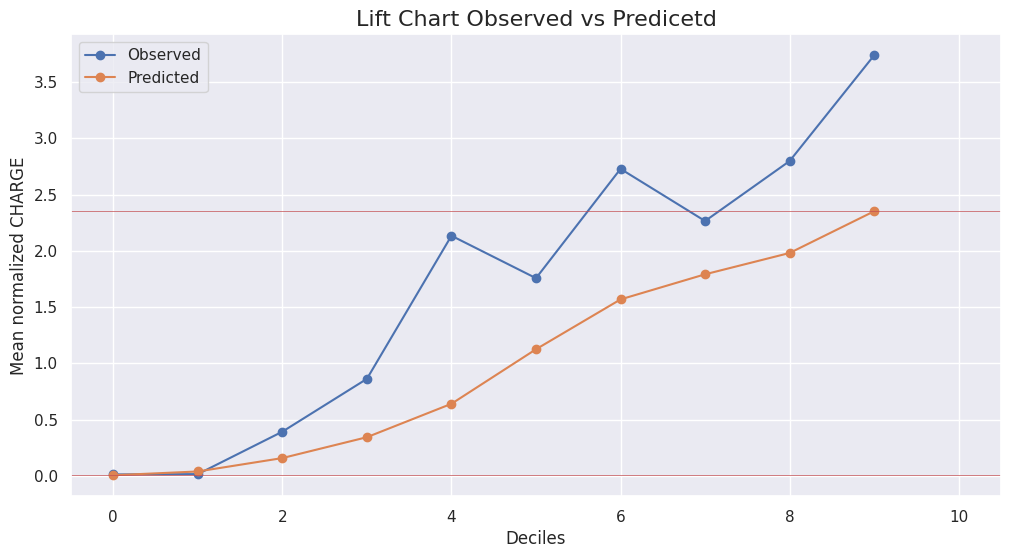

In [58]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_cb_tweedie)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLiftChart.pdf')

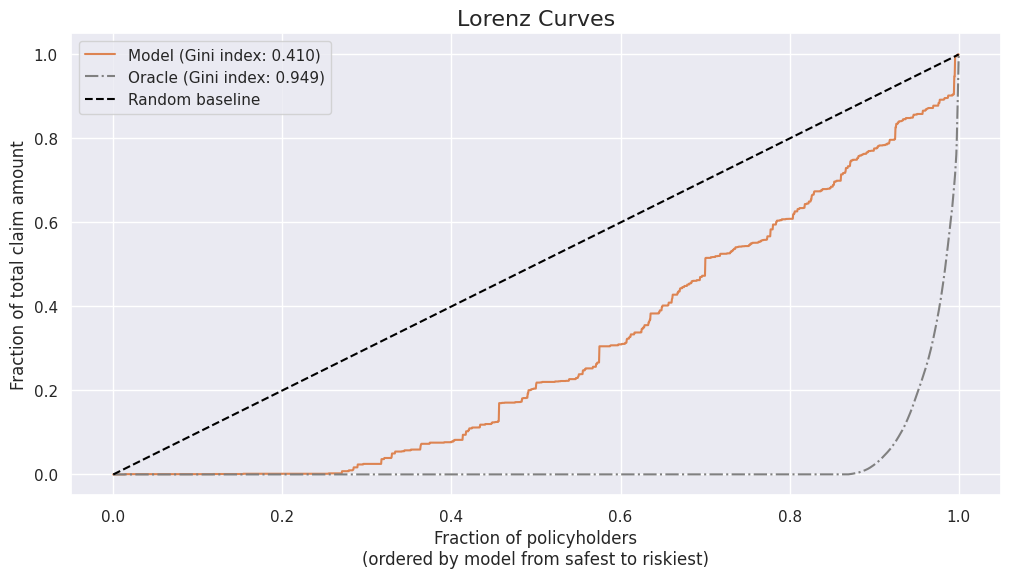

In [59]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_cb_tweedie)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLorenzCurve.pdf')

## XGBRegressor

In [40]:
xgb_tweedie = XGBRegressor(objective='reg:tweedie',
                           max_depth=4,
                           learning_rate=0.042029862461369125,
                           colsample_bytree=0.5711895944308994,
                           subsample=0.5411213855618349,
                           alpha=5.835067732086724,
                           #lambda=6.276955677369005,
                           min_child_weight=695.0944784712658,
                           tweedie_variance_power=1.2149336293286312,
                           early_stopping_rounds=50,
                           random_state=13
                       )
xgb_tweedie.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)
y_pred_xgb_tweedie = xgb_tweedie.predict(X_test)

In [42]:
print('MSLE score:')
print('\tXGBoost tweedie loss\t', mean_squared_log_error(y_test, y_pred_xgb_tweedie))

MSLE score:
	XGBoost tweedie loss	 20.52798099794401


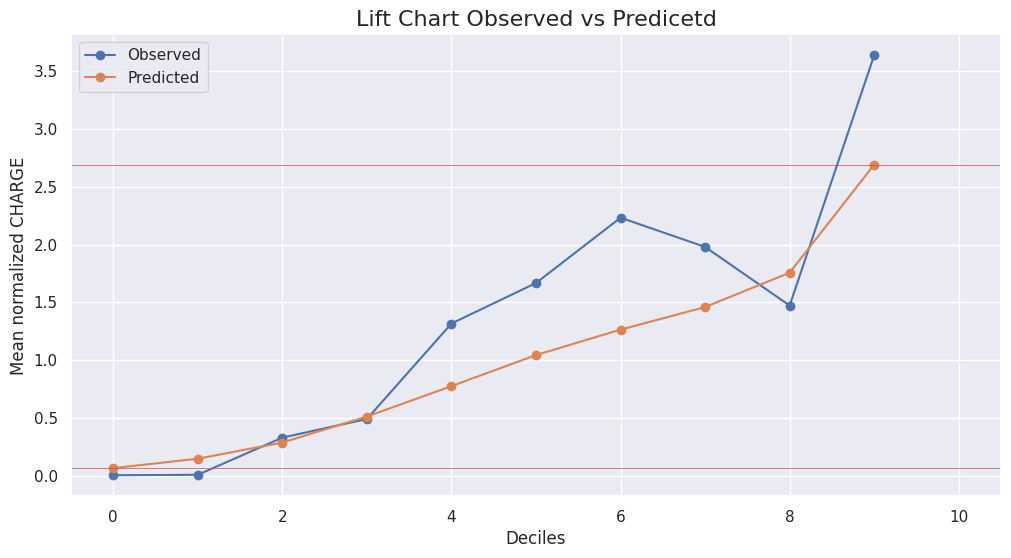

In [43]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_xgb_tweedie)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLiftChart.pdf')

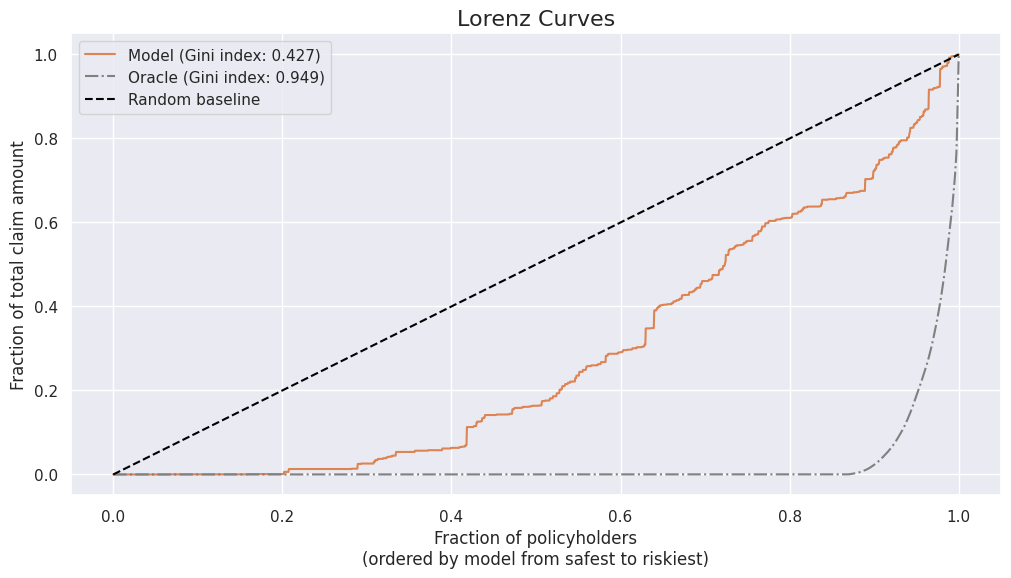

In [44]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_xgb_tweedie)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLorenzCurve.pdf')

In [50]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [53]:
lgbm_tweedie = LGBMRegressor(objective='tweedie',
                             metric='RMSE',
                             random_state=13,
                             n_estimators=10000,
                             reg_alpha=0.22526419797625372,
                             reg_lambda=0.0005017660037025761,
                             colsample_bytree=0.8789442128781528,
                             subsample=0.6622594582915033,
                             learning_rate=0.18480913197165794,
                             max_depth=4,
                             num_leaves=85,
                             min_child_samples=61,cat_smooth=97,
                             force_col_wise=True,
                             tweedie_variance_power=1.4301760484836454,
                             verbosity=-1)


lgbm_tweedie.fit(X_train, y_train,
                 eval_set=[(X_val, y_val)],
                 eval_metric='rmse',
                 callbacks=[early_stopping(stopping_rounds=50),
                            log_evaluation(period=20, show_stdv=True),
             ]
        )
y_pred_lgbm_tweedie = lgbm_tweedie.predict(X_test)

Training until validation scores don't improve for 50 rounds
[20]	valid_0's rmse: 1475.29
[40]	valid_0's rmse: 1480.84
[60]	valid_0's rmse: 1480.77
Early stopping, best iteration is:
[19]	valid_0's rmse: 1474.44


In [54]:
print('MSLE score:')
print('\tXGBoost tweedie loss\t', mean_squared_log_error(y_test, y_pred_lgbm_tweedie))

MSLE score:
	XGBoost tweedie loss	 19.862173628320605


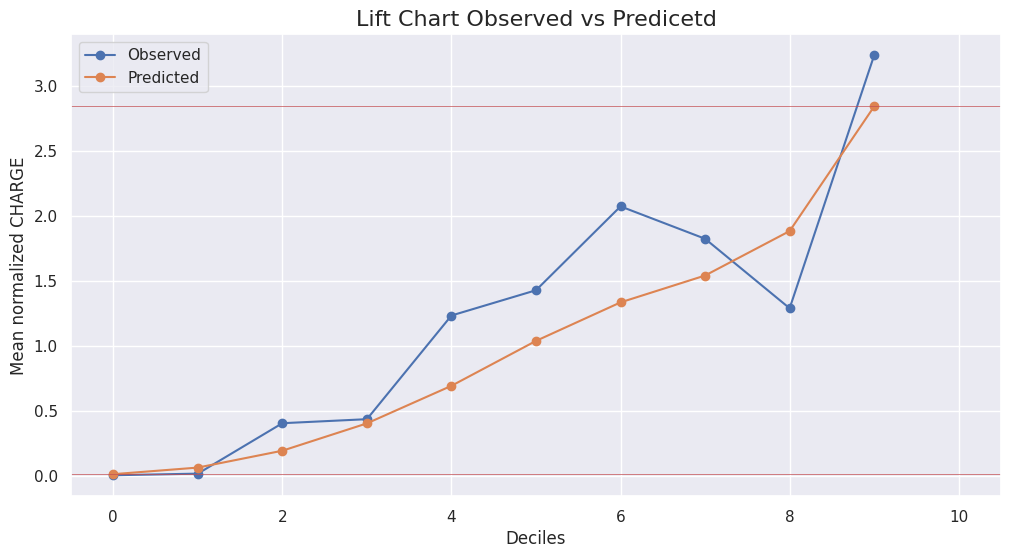

In [56]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_lgbm_tweedie)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLiftChart.pdf')

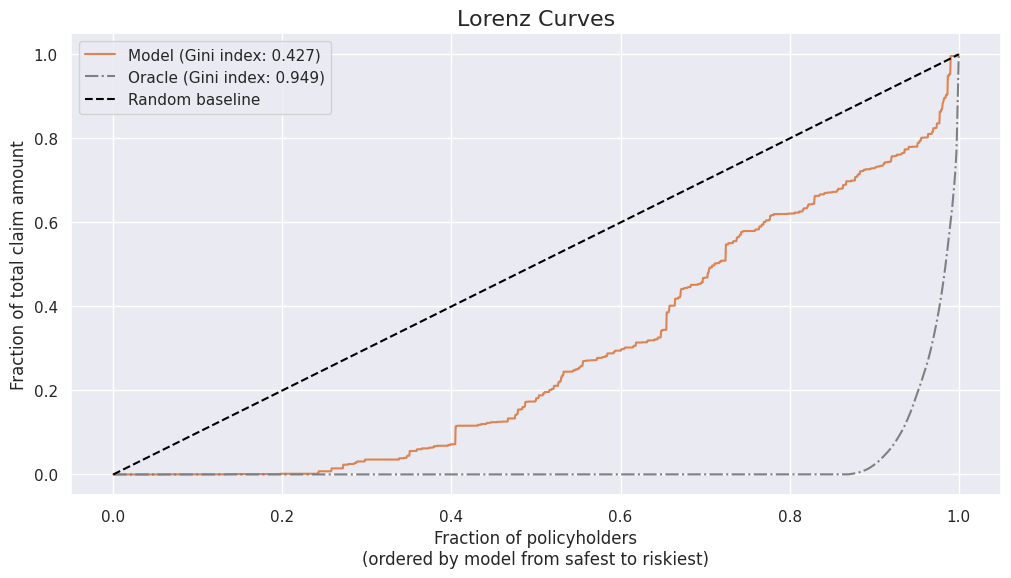

In [57]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_lgbm_tweedie)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLorenzCurve.pdf')